# <center> Предсказание победителя в Dota 2
<center> <img src="https://meduza.io/impro/YnJZAHUW6WHz_JQm1uRPkTql_qAhbfxt3oFJLGH7CJg/fill/980/0/ce/1/aHR0cHM6Ly9tZWR1/emEuaW8vaW1hZ2Uv/YXR0YWNobWVudHMv/aW1hZ2VzLzAwNy8x/NTcvNjk1L29yaWdp/bmFsL0tMVThLbUti/ZG5pSzlibDA0Wmlw/WXcuanBn.webp" width="700" height="700">

[Почитать подробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку. 

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [152]:
import os
import json
import pandas as pd
import numpy as np
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

%matplotlib inline

In [2]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## все посылки и значения с каггла

submission_2022-03-20_20-17-34.csv - Score: 0.78639 (бейзлайн)

submission_2022-04-03_16-58-12.csv - Score: 0.80162 (первая попытка потыкать)

submission_2022-04-03_21-00-13.csv - Score: 0.80361 (вторая попытка потыкать)

submission_2022-04-03_23-32-45.csv - Score: 0.81371 (3 попытка и последняя)

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные 
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [3]:
PATH_TO_DATA = "./bi-2021-ml-competitions-dota2"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")

In [4]:
df_train_features.shape

(31698, 245)

In [5]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колонки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [6]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


## <left>Наша первая модель

In [7]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

#### Обучим случайный лес

In [9]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

CPU times: user 27.1 s, sys: 137 ms, total: 27.3 s
Wall time: 7.49 s


RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

#### Сделаем предсказания и оценим качество на отложенной части данных

In [10]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

In [11]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7754387258058622


Посмотрим на accuracy:

In [12]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.6885383806519453


## <left>Посылка

In [13]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")

X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [14]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-03-20_20-17-34.csv


## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [15]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [16]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

CPU times: user 6.16 s, sys: 659 ms, total: 6.81 s
Wall time: 51.8 s


In [17]:
cv_scores_rf

array([0.77543873, 0.77343884, 0.76649967, 0.7722681 , 0.77246001])

In [18]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7720210676055513


## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [19]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строку
    for i in range(419):
        line = fin.readline()
    
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

In [20]:
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]

(0, 5, 5)

In [125]:
player

{'player_slot': 132,
 'hero_id': 83,
 'hero_name': 'npc_dota_hero_treant',
 'account_id_hash': '116aa09d7684da7a6bc388276b1abd1a',
 'ability_upgrades': [{'ability': 5434, 'time': 285, 'level': 1},
  {'ability': 5436, 'time': 488, 'level': 2},
  {'ability': 5436, 'time': 672, 'level': 3},
  {'ability': 5435, 'time': 913, 'level': 4},
  {'ability': 5437, 'time': 1144, 'level': 5},
  {'ability': 5436, 'time': 1145, 'level': 6},
  {'ability': 5436, 'time': 1360, 'level': 7},
  {'ability': 5435, 'time': 1527, 'level': 8},
  {'ability': 5435, 'time': 1660, 'level': 9},
  {'ability': 6024, 'time': 1687, 'level': 10},
  {'ability': 5435, 'time': 1916, 'level': 11}],
 'obs_placed': 8,
 'sen_placed': 0,
 'creeps_stacked': 0,
 'camps_stacked': 0,
 'rune_pickups': 17,
 'firstblood_claimed': 0,
 'teamfight_participation': 0.217,
 'towers_killed': 0,
 'roshans_killed': 0,
 'observers_placed': 8,
 'stuns': 33.337,
 'max_hero_hit': {'type': 'max_hero_hit',
  'time': 2010.079,
  'max': True,
  'inflict

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

Информация о количестве использованных способностей:

In [21]:
player["ability_uses"]

{'treant_living_armor': 52, 'treant_leech_seed': 5, 'treant_overgrowth': 5}

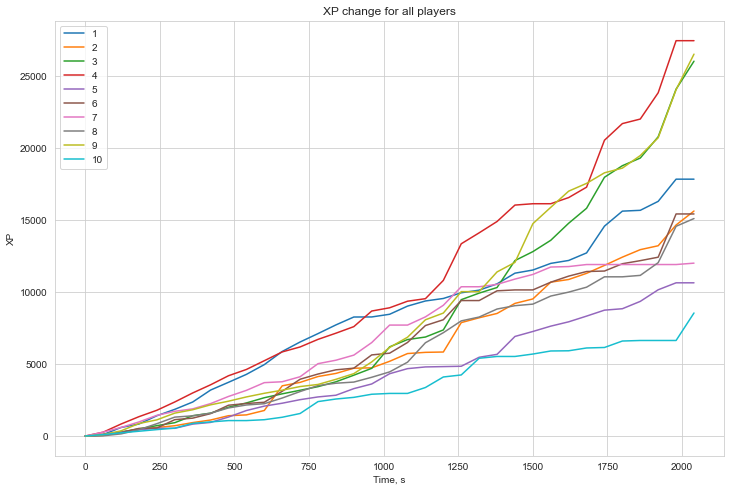

In [22]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [23]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

    
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [24]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [61]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

A Jupyter Widget

In [26]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0.00,0,0,0,0,2.0,0.0,2.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,3,0,0.25,0,0,3,0,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0,1,0.50,0,0,3,0,0.0,1.0,-1.0


In [27]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 105 ms, sys: 160 ms, total: 264 ms
Wall time: 1min 25s


In [28]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.778796825263235


Видно, что случайный лес стал работать немного лучше при добавлении новых признаков. A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!

## Штош

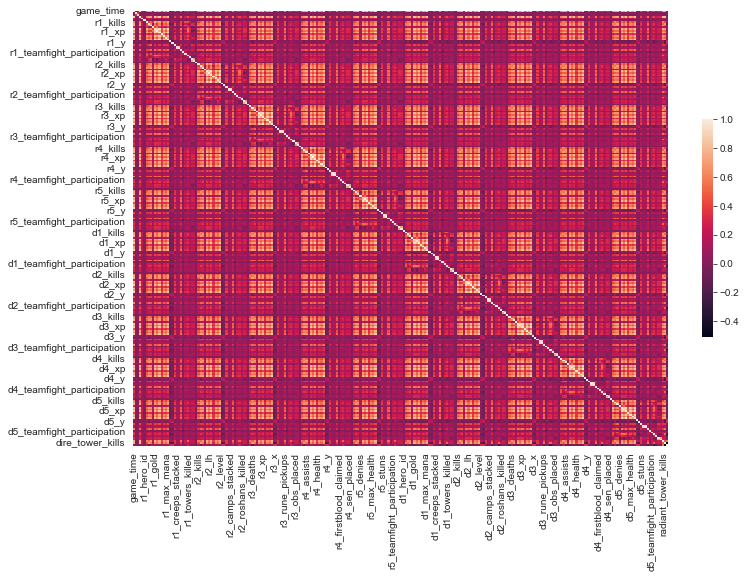

In [34]:
# пойдем своим нубским путем и начнем с EDA
#df_train_features_extended.corr()
sns.heatmap(df_train_features_extended.corr());

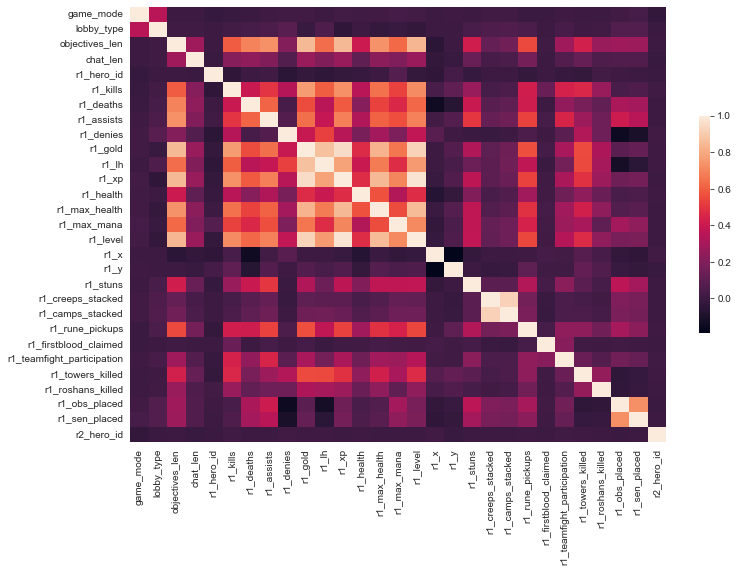

In [39]:
# видно, что признаки разбиваются на 10 каких-то групп, где есть сильные коррелляции. 
# попробую сделать то же самое, только для первых 30 колонок (хочу просто посмотреть, что там с чем корреллирует)
sns.heatmap(df_train_features_extended.iloc[:, 1:30].corr(), cbar_kws={"shrink": 0.5});

In [40]:
# похоже, что там есть набор данных по каждому персонажу, который участвовал в бое
#(всего 2 команды по 5 персонажей, поэтому и 10 "клеток" было на большом хитмапе)
# сильная положительная коррелляция - gold, xp, level - возможно, можно с ними что-нибудь сделать 
#(оставить только xp, например)
# и еще ID героев - это номинативные признаки (хотя они циферки), но кажется, что от самого по себе айдишника 
# мало что зависит, так что хочу их убрать
# и еще, честно говоря, координаты тоже хочется убрать (О_о они же вроде как двигаются)

# итого, план такой: 
# 1) убираем айдишники и координаты
# 2) оставляем только xp из gold, xp, level 
# 3) пробуем подобрать параметры для леса в gridsearch/randomizedsearch

In [101]:
cols_to_drop = ['r1_hero_id', 'r1_gold', 'r1_level', 'r1_x', 'r1_y',
               'r2_hero_id', 'r2_gold', 'r2_level', 'r2_x', 'r2_y',
               'r3_hero_id', 'r3_gold', 'r3_level', 'r3_x', 'r3_y',
               'r4_hero_id', 'r4_gold', 'r4_level', 'r4_x', 'r4_y',
               'r5_hero_id', 'r5_gold', 'r5_level', 'r5_x', 'r5_y',
               'd1_hero_id', 'd1_gold', 'd1_level', 'd1_x', 'd1_y',
               'd2_hero_id', 'd2_gold', 'd2_level', 'd2_x', 'd2_y',
               'd3_hero_id', 'd3_gold', 'd3_level', 'd3_x', 'd3_y',
               'd4_hero_id', 'd4_gold', 'd4_level', 'd4_x', 'd4_y',
               'd5_hero_id', 'd5_gold', 'd5_level', 'd5_x', 'd5_y']
df_train_features_extended_nofeat_01 = df_train_features_extended.drop(cols_to_drop, axis=1)
df_train_features_extended_nofeat_01

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_kills,r1_deaths,r1_assists,r1_denies,r1_lh,...,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,7,2,0,7,52,...,0,0,0.000000,0,0,0,0,2.0,0.0,2.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,0,0,0,0,0,...,0,0,0.000000,0,0,0,0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,0,0,0,1,0,...,0,0,0.000000,0,0,0,0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,0,3,3,5,1,...,3,0,0.250000,0,0,3,0,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,3,1,2,9,40,...,0,1,0.500000,0,0,3,0,0.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,2666,22,0,23,8,9,11,9,3,251,...,17,0,0.390244,2,2,0,0,4.0,8.0,-4.0
308faee28efee2e66b39f9f2ba6ea9cf,2525,22,0,15,5,3,9,14,3,151,...,10,0,0.263158,0,0,15,6,6.0,4.0,2.0
6066cc7417b43c749d551e123d00f0c8,1002,4,0,4,0,1,2,1,0,59,...,15,1,0.555556,0,0,0,0,2.0,1.0,1.0


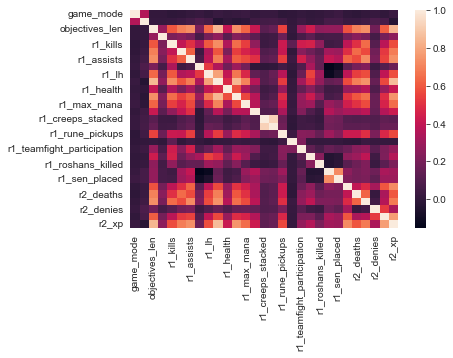

In [102]:
# попробуем снова heatmap
sns.heatmap(df_train_features_extended_nofeat_01.iloc[:, 1:30].corr());

In [103]:
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(df_train_features_extended_nofeat_01, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

In [104]:
rf_superbasic = RandomForestClassifier()

In [105]:
rf_parameters = {'n_estimators': range(100, 1000, 100),
                 'criterion': ['gini', 'entropy'], 
                 'max_depth': range(2, 20, 4), 
                 'min_samples_split': range(2, 10, 2), 
                 'min_samples_leaf' : range(2, 6, 2)}

In [106]:
%%time
random_search_cv_clf = RandomizedSearchCV(rf_superbasic, rf_parameters, cv=5, n_jobs=2, random_state=SEED)
random_search_cv_clf.fit(X_train_2, y_train_2)

CPU times: user 1min 23s, sys: 910 ms, total: 1min 24s
Wall time: 21min 46s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=2,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(2, 20, 4),
                                        'min_samples_leaf': range(2, 6, 2),
                                        'min_samples_split': range(2, 10, 2),
                                        'n_estimators': range(100, 1000, 100)},
                   random_state=10801)

In [107]:
rf_best_random = random_search_cv_clf.best_estimator_
rf_best_random

# зафиксируем на всякий параметры: 
# RandomForestClassifier(max_depth=18, min_samples_leaf=2, min_samples_split=8, n_estimators=700)

RandomForestClassifier(max_depth=18, min_samples_leaf=2, min_samples_split=8,
                       n_estimators=700)

In [108]:
cv_scores_rf_best_random = cross_val_score(rf_best_random, df_train_features_extended_nofeat_01, y, 
                                           cv=cv, scoring="roc_auc")

In [109]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf_best_random.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7902223553473846


In [112]:
# надо сделать файлик

df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")

X_test = df_test_features
# и еще не забыть добавить фичи
add_new_features(X_test, os.path.join(PATH_TO_DATA, "test_raw_data.jsonl"))
# и убрать фичи
X_test = X_test.drop(cols_to_drop, axis=1)

y_test_pred = rf_best_random.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

A Jupyter Widget

Файл посылки сохранен, как: submission_2022-04-03_16-58-12.csv


In [120]:
# оаоаоа, что-то получилось О_о 
# метрика KDA, может быть и хорошая, но там можно впилиться в NA (чего я пока не хочу делать), 
# поэтому решила ввести метрику KA = kill + assist

df_train_features_extended_nofeat_02 = df_train_features_extended_nofeat_01.copy()
df_train_features_extended_nofeat_02['r1_ka'] = df_train_features_extended_nofeat_02['r1_kills'] + df_train_features_extended_nofeat_02['r1_assists']
df_train_features_extended_nofeat_02['r2_ka'] = df_train_features_extended_nofeat_02['r2_kills'] + df_train_features_extended_nofeat_02['r2_assists']
df_train_features_extended_nofeat_02['r3_ka'] = df_train_features_extended_nofeat_02['r3_kills'] + df_train_features_extended_nofeat_02['r3_assists']
df_train_features_extended_nofeat_02['r4_ka'] = df_train_features_extended_nofeat_02['r4_kills'] + df_train_features_extended_nofeat_02['r4_assists']
df_train_features_extended_nofeat_02['r5_ka'] = df_train_features_extended_nofeat_02['r5_kills'] + df_train_features_extended_nofeat_02['r5_assists']
df_train_features_extended_nofeat_02['d1_ka'] = df_train_features_extended_nofeat_02['d1_kills'] + df_train_features_extended_nofeat_02['d1_assists']
df_train_features_extended_nofeat_02['d2_ka'] = df_train_features_extended_nofeat_02['d2_kills'] + df_train_features_extended_nofeat_02['d2_assists']
df_train_features_extended_nofeat_02['d3_ka'] = df_train_features_extended_nofeat_02['d3_kills'] + df_train_features_extended_nofeat_02['d3_assists']
df_train_features_extended_nofeat_02['d4_ka'] = df_train_features_extended_nofeat_02['d4_kills'] + df_train_features_extended_nofeat_02['d4_assists']
df_train_features_extended_nofeat_02['d5_ka'] = df_train_features_extended_nofeat_02['d5_kills'] + df_train_features_extended_nofeat_02['d5_assists']

cols_to_del_from02 = ['r1_kills', 'r1_assists',
                     'r2_kills', 'r2_assists',
                     'r3_kills', 'r3_assists',
                     'r4_kills', 'r4_assists',
                     'r5_kills', 'r5_assists',
                     'd1_kills', 'd1_assists',
                     'd2_kills', 'd2_assists',
                     'd3_kills', 'd3_assists',
                     'd4_kills', 'd4_assists',
                     'd5_kills', 'd5_assists']

df_train_features_extended_nofeat_02 = df_train_features_extended_nofeat_02.drop(cols_to_del_from02, axis=1)

In [121]:
df_train_features_extended_nofeat_02

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_deaths,r1_denies,r1_lh,r1_xp,r1_health,...,r1_ka,r2_ka,r3_ka,r4_ka,r5_ka,d1_ka,d2_ka,d3_ka,d4_ka,d5_ka
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,2,7,52,3937,1160,...,7,5,5,7,6,1,1,2,2,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,0,0,0,0,680,...,0,0,0,0,0,0,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,0,1,0,359,740,...,0,0,0,0,0,0,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,3,5,1,2828,495,...,3,8,2,4,4,4,4,7,6,3
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,1,9,40,3964,495,...,5,3,4,1,0,6,2,5,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,2666,22,0,23,8,11,3,251,25448,0,...,18,20,15,20,17,23,31,26,28,16
308faee28efee2e66b39f9f2ba6ea9cf,2525,22,0,15,5,9,3,151,19592,1478,...,17,11,10,15,10,7,8,12,1,5
6066cc7417b43c749d551e123d00f0c8,1002,4,0,4,0,2,0,59,4478,880,...,2,3,3,4,5,8,5,10,12,10


In [122]:
# попробуем поучить на этом кадаврике
X_train_3, X_valid_3, y_train_3, y_valid_3 = train_test_split(df_train_features_extended_nofeat_02, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)
random_search_cv_clf.fit(X_train_3, y_train_3)
rf_best_random_02 = random_search_cv_clf.best_estimator_
rf_best_random_02
#фиксируем
#RandomForestClassifier(max_depth=18, min_samples_leaf=2, min_samples_split=8, n_estimators=700)

RandomForestClassifier(max_depth=18, min_samples_leaf=2, min_samples_split=8,
                       n_estimators=700)

In [123]:
cv_scores_rf_best_random02 = cross_val_score(rf_best_random_02, df_train_features_extended_nofeat_02, y, 
                                           cv=cv, scoring="roc_auc")
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf_best_random02.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7907090072106199


In [124]:
# надо сделать файлик 02

df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")

X_test = df_test_features
# и еще не забыть добавить фичи
add_new_features(X_test, os.path.join(PATH_TO_DATA, "test_raw_data.jsonl"))
# и убрать фичи
X_test = X_test.drop(cols_to_drop, axis=1)
X_test['r1_ka'] = X_test['r1_kills'] + X_test['r1_assists']
X_test['r2_ka'] = X_test['r2_kills'] + X_test['r2_assists']
X_test['r3_ka'] = X_test['r3_kills'] + X_test['r3_assists']
X_test['r4_ka'] = X_test['r4_kills'] + X_test['r4_assists']
X_test['r5_ka'] = X_test['r5_kills'] + X_test['r5_assists']
X_test['d1_ka'] = X_test['d1_kills'] + X_test['d1_assists']
X_test['d2_ka'] = X_test['d2_kills'] + X_test['d2_assists']
X_test['d3_ka'] = X_test['d3_kills'] + X_test['d3_assists']
X_test['d4_ka'] = X_test['d4_kills'] + X_test['d4_assists']
X_test['d5_ka'] = X_test['d5_kills'] + X_test['d5_assists']
X_test = X_test.drop(cols_to_del_from02, axis=1)

y_test_pred = rf_best_random_02.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

A Jupyter Widget

Файл посылки сохранен, как: submission_2022-04-03_21-00-13.csv


In [126]:
# ROC-AUC на кросс-валидации почти не изменился, все равно попробуем закинуть на каггл

In [159]:
# а теперь ход конем - объединяем все признаким по командам О_о 

df_train_features_extended_nofeat_03 = df_train_features_extended_nofeat_01.iloc[:, 1:5].copy()

# бесконечные суммы
df_train_features_extended_nofeat_03['r_ka'] = df_train_features_extended_nofeat_02['r1_ka'] + df_train_features_extended_nofeat_02['r2_ka'] + df_train_features_extended_nofeat_02['r3_ka'] + df_train_features_extended_nofeat_02['r4_ka'] + df_train_features_extended_nofeat_02['r5_ka']
df_train_features_extended_nofeat_03['r_deaths'] = df_train_features_extended_nofeat_01['r1_deaths'] + df_train_features_extended_nofeat_01['r2_deaths'] + df_train_features_extended_nofeat_01['r3_deaths'] + df_train_features_extended_nofeat_01['r4_deaths'] + df_train_features_extended_nofeat_01['r5_deaths']
df_train_features_extended_nofeat_03['r_denies'] = df_train_features_extended_nofeat_01['r1_denies'] + df_train_features_extended_nofeat_01['r2_denies'] + df_train_features_extended_nofeat_01['r3_denies'] + df_train_features_extended_nofeat_01['r4_denies'] + df_train_features_extended_nofeat_01['r5_denies']
df_train_features_extended_nofeat_03['r_lh'] = df_train_features_extended_nofeat_01['r1_lh'] + df_train_features_extended_nofeat_01['r2_lh'] + df_train_features_extended_nofeat_01['r3_lh'] + df_train_features_extended_nofeat_01['r4_lh'] + df_train_features_extended_nofeat_01['r5_lh']
df_train_features_extended_nofeat_03['r_xp'] = df_train_features_extended_nofeat_01['r1_xp'] + df_train_features_extended_nofeat_01['r2_xp'] + df_train_features_extended_nofeat_01['r3_xp'] + df_train_features_extended_nofeat_01['r4_xp'] + df_train_features_extended_nofeat_01['r5_xp']
df_train_features_extended_nofeat_03['r_health'] = df_train_features_extended_nofeat_01['r1_health'] + df_train_features_extended_nofeat_01['r2_health'] + df_train_features_extended_nofeat_01['r3_health'] + df_train_features_extended_nofeat_01['r4_health'] + df_train_features_extended_nofeat_01['r5_health']
df_train_features_extended_nofeat_03['r_max_health'] = df_train_features_extended_nofeat_01['r1_max_health'] + df_train_features_extended_nofeat_01['r2_max_health'] + df_train_features_extended_nofeat_01['r3_max_health'] + df_train_features_extended_nofeat_01['r4_max_health'] + df_train_features_extended_nofeat_01['r5_max_health']
df_train_features_extended_nofeat_03['r_max_mana'] = df_train_features_extended_nofeat_01['r1_max_mana'] +  df_train_features_extended_nofeat_01['r2_max_mana'] + df_train_features_extended_nofeat_01['r3_max_mana'] + df_train_features_extended_nofeat_01['r4_max_mana'] + df_train_features_extended_nofeat_01['r5_max_mana']
df_train_features_extended_nofeat_03['r_stuns'] = df_train_features_extended_nofeat_01['r1_stuns'] + df_train_features_extended_nofeat_01['r2_stuns'] + df_train_features_extended_nofeat_01['r3_stuns'] + df_train_features_extended_nofeat_01['r4_stuns'] + df_train_features_extended_nofeat_01['r5_stuns']
df_train_features_extended_nofeat_03['r_creeps_stacked'] = df_train_features_extended_nofeat_01['r1_creeps_stacked'] + df_train_features_extended_nofeat_01['r2_creeps_stacked'] +  df_train_features_extended_nofeat_01['r3_creeps_stacked'] + df_train_features_extended_nofeat_01['r4_creeps_stacked'] + df_train_features_extended_nofeat_01['r5_creeps_stacked']
df_train_features_extended_nofeat_03['r_camps_stacked'] = df_train_features_extended_nofeat_01['r1_camps_stacked'] + df_train_features_extended_nofeat_01['r2_camps_stacked'] + df_train_features_extended_nofeat_01['r3_camps_stacked'] + df_train_features_extended_nofeat_01['r4_camps_stacked'] + df_train_features_extended_nofeat_01['r5_camps_stacked']
df_train_features_extended_nofeat_03['r_rune_pickups'] = df_train_features_extended_nofeat_01['r1_rune_pickups'] + df_train_features_extended_nofeat_01['r2_rune_pickups'] + df_train_features_extended_nofeat_01['r3_rune_pickups'] + df_train_features_extended_nofeat_01['r4_rune_pickups'] + df_train_features_extended_nofeat_01['r5_rune_pickups']
df_train_features_extended_nofeat_03['r_firstblood_claimed'] = df_train_features_extended_nofeat_01['r1_firstblood_claimed'] + df_train_features_extended_nofeat_01['r2_firstblood_claimed'] + df_train_features_extended_nofeat_01['r3_firstblood_claimed'] + df_train_features_extended_nofeat_01['r4_firstblood_claimed'] + df_train_features_extended_nofeat_01['r5_firstblood_claimed']
df_train_features_extended_nofeat_03['r_teamfight_participation'] = df_train_features_extended_nofeat_01['r1_teamfight_participation'] + df_train_features_extended_nofeat_01['r2_teamfight_participation'] + df_train_features_extended_nofeat_01['r3_teamfight_participation'] + df_train_features_extended_nofeat_01['r4_teamfight_participation'] + df_train_features_extended_nofeat_01['r5_teamfight_participation']
df_train_features_extended_nofeat_03['r_towers_killed'] = df_train_features_extended_nofeat_01['r1_towers_killed'] + df_train_features_extended_nofeat_01['r2_towers_killed'] + df_train_features_extended_nofeat_01['r3_towers_killed'] + df_train_features_extended_nofeat_01['r4_towers_killed'] + df_train_features_extended_nofeat_01['r5_towers_killed']
df_train_features_extended_nofeat_03['r_roshans_killed'] = df_train_features_extended_nofeat_01['r1_roshans_killed'] + df_train_features_extended_nofeat_01['r2_roshans_killed'] + df_train_features_extended_nofeat_01['r3_roshans_killed'] + df_train_features_extended_nofeat_01['r4_roshans_killed'] + df_train_features_extended_nofeat_01['r5_roshans_killed']
df_train_features_extended_nofeat_03['r_obs_placed'] = df_train_features_extended_nofeat_01['r1_obs_placed'] + df_train_features_extended_nofeat_01['r2_obs_placed'] + df_train_features_extended_nofeat_01['r3_obs_placed'] + df_train_features_extended_nofeat_01['r4_obs_placed'] + df_train_features_extended_nofeat_01['r5_obs_placed']
df_train_features_extended_nofeat_03['r_sen_placed'] = df_train_features_extended_nofeat_01['r1_sen_placed'] + df_train_features_extended_nofeat_01['r2_sen_placed'] + df_train_features_extended_nofeat_01['r3_sen_placed'] + df_train_features_extended_nofeat_01['r4_sen_placed'] + df_train_features_extended_nofeat_01['r5_sen_placed']

df_train_features_extended_nofeat_03['d_ka'] = df_train_features_extended_nofeat_02['d1_ka'] + df_train_features_extended_nofeat_02['d2_ka'] + df_train_features_extended_nofeat_02['d3_ka'] + df_train_features_extended_nofeat_02['d4_ka'] + df_train_features_extended_nofeat_02['d5_ka']
df_train_features_extended_nofeat_03['d_deaths'] = df_train_features_extended_nofeat_01['d1_deaths'] + df_train_features_extended_nofeat_01['d2_deaths'] + df_train_features_extended_nofeat_01['d3_deaths'] + df_train_features_extended_nofeat_01['d4_deaths'] + df_train_features_extended_nofeat_01['d5_deaths']
df_train_features_extended_nofeat_03['d_denies'] = df_train_features_extended_nofeat_01['d1_denies'] + df_train_features_extended_nofeat_01['d2_denies'] + df_train_features_extended_nofeat_01['d3_denies'] + df_train_features_extended_nofeat_01['d4_denies'] + df_train_features_extended_nofeat_01['d5_denies']
df_train_features_extended_nofeat_03['d_lh'] = df_train_features_extended_nofeat_01['d1_lh'] + df_train_features_extended_nofeat_01['d2_lh'] + df_train_features_extended_nofeat_01['d3_lh'] + df_train_features_extended_nofeat_01['d4_lh'] + df_train_features_extended_nofeat_01['d5_lh']
df_train_features_extended_nofeat_03['d_xp'] = df_train_features_extended_nofeat_01['d1_xp'] + df_train_features_extended_nofeat_01['d2_xp'] + df_train_features_extended_nofeat_01['d3_xp'] + df_train_features_extended_nofeat_01['d4_xp'] + df_train_features_extended_nofeat_01['d5_xp']
df_train_features_extended_nofeat_03['d_health'] = df_train_features_extended_nofeat_01['d1_health'] + df_train_features_extended_nofeat_01['d2_health'] + df_train_features_extended_nofeat_01['d3_health'] + df_train_features_extended_nofeat_01['d4_health'] + df_train_features_extended_nofeat_01['d5_health']
df_train_features_extended_nofeat_03['d_max_health'] = df_train_features_extended_nofeat_01['d1_max_health'] + df_train_features_extended_nofeat_01['d2_max_health'] + df_train_features_extended_nofeat_01['d3_max_health'] + df_train_features_extended_nofeat_01['d4_max_health'] + df_train_features_extended_nofeat_01['d5_max_health']
df_train_features_extended_nofeat_03['d_max_mana'] = df_train_features_extended_nofeat_01['d1_max_mana'] + df_train_features_extended_nofeat_01['d2_max_mana'] + df_train_features_extended_nofeat_01['d3_max_mana'] + df_train_features_extended_nofeat_01['d4_max_mana'] + df_train_features_extended_nofeat_01['d5_max_mana']
df_train_features_extended_nofeat_03['d_stuns'] = df_train_features_extended_nofeat_01['d1_stuns'] + df_train_features_extended_nofeat_01['d2_stuns'] + df_train_features_extended_nofeat_01['d3_stuns'] + df_train_features_extended_nofeat_01['d4_stuns'] + df_train_features_extended_nofeat_01['d5_stuns']
df_train_features_extended_nofeat_03['d_creeps_stacked'] = df_train_features_extended_nofeat_01['d1_creeps_stacked'] + df_train_features_extended_nofeat_01['d2_creeps_stacked'] + df_train_features_extended_nofeat_01['d3_creeps_stacked'] + df_train_features_extended_nofeat_01['d4_creeps_stacked'] + df_train_features_extended_nofeat_01['d5_creeps_stacked']
df_train_features_extended_nofeat_03['d_camps_stacked'] = df_train_features_extended_nofeat_01['d1_camps_stacked'] + df_train_features_extended_nofeat_01['d2_camps_stacked'] + df_train_features_extended_nofeat_01['d3_camps_stacked'] + df_train_features_extended_nofeat_01['d4_camps_stacked'] + df_train_features_extended_nofeat_01['d5_camps_stacked']
df_train_features_extended_nofeat_03['d_rune_pickups'] = df_train_features_extended_nofeat_01['d1_rune_pickups'] + df_train_features_extended_nofeat_01['d2_rune_pickups'] + df_train_features_extended_nofeat_01['d3_rune_pickups'] + df_train_features_extended_nofeat_01['d4_rune_pickups'] + df_train_features_extended_nofeat_01['d5_rune_pickups']
df_train_features_extended_nofeat_03['d_firstblood_claimed'] = df_train_features_extended_nofeat_01['r1_firstblood_claimed'] + df_train_features_extended_nofeat_01['d2_firstblood_claimed'] + df_train_features_extended_nofeat_01['d3_firstblood_claimed'] + df_train_features_extended_nofeat_01['d4_firstblood_claimed'] + df_train_features_extended_nofeat_01['d5_firstblood_claimed']
df_train_features_extended_nofeat_03['d_teamfight_participation'] = df_train_features_extended_nofeat_01['d1_teamfight_participation'] + df_train_features_extended_nofeat_01['d2_teamfight_participation'] + df_train_features_extended_nofeat_01['d3_teamfight_participation'] + df_train_features_extended_nofeat_01['d4_teamfight_participation'] + df_train_features_extended_nofeat_01['d5_teamfight_participation']
df_train_features_extended_nofeat_03['d_towers_killed'] = df_train_features_extended_nofeat_01['d1_towers_killed'] + df_train_features_extended_nofeat_01['d2_towers_killed'] + df_train_features_extended_nofeat_01['d3_towers_killed'] + df_train_features_extended_nofeat_01['d4_towers_killed'] + df_train_features_extended_nofeat_01['d5_towers_killed']
df_train_features_extended_nofeat_03['d_roshans_killed'] = df_train_features_extended_nofeat_01['d1_roshans_killed'] + df_train_features_extended_nofeat_01['d2_roshans_killed'] + df_train_features_extended_nofeat_01['d3_roshans_killed'] + df_train_features_extended_nofeat_01['d4_roshans_killed'] + df_train_features_extended_nofeat_01['d5_roshans_killed']
df_train_features_extended_nofeat_03['d_obs_placed'] = df_train_features_extended_nofeat_01['d1_obs_placed'] + df_train_features_extended_nofeat_01['d2_obs_placed'] + df_train_features_extended_nofeat_01['d3_obs_placed'] + df_train_features_extended_nofeat_01['d4_obs_placed'] + df_train_features_extended_nofeat_01['d5_obs_placed']
df_train_features_extended_nofeat_03['d_sen_placed'] = df_train_features_extended_nofeat_01['d1_sen_placed'] + df_train_features_extended_nofeat_01['d2_sen_placed'] + df_train_features_extended_nofeat_01['d3_sen_placed'] + df_train_features_extended_nofeat_01['d4_sen_placed'] + df_train_features_extended_nofeat_01['d5_sen_placed']


# и еще фичу из json, раз уж ее любезно посчитали))
add_new_features(df_train_features_extended_nofeat_03, os.path.join(PATH_TO_DATA, "train_raw_data.jsonl"))

A Jupyter Widget

In [161]:
df_train_features_extended_nofeat_03

,game_mode,lobby_type,objectives_len,chat_len,r_ka,r_deaths,r_denies,r_lh,r_xp,r_health,...,d_rune_pickups,d_firstblood_claimed,d_teamfight_participation,d_towers_killed,d_roshans_killed,d_obs_placed,d_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,4,0,3,10,30,4,28,127,17566,4498,...,14,1,1.500000,0,0,5,2,2.0,0.0,2.0
6db558535151ea18ca70a6892197db41,23,0,0,0,0,0,0,0,0,3128,...,1,0,0.000000,0,0,0,0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,22,7,0,0,0,0,9,18,2942,3343,...,0,0,0.000000,0,0,0,0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,22,0,1,0,21,12,33,215,26116,4873,...,12,0,2.000000,0,0,7,1,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,22,7,2,2,13,10,37,141,13044,3344,...,12,1,2.000000,1,0,4,1,0.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,22,0,23,8,90,41,40,955,101263,1794,...,57,0,3.000000,9,2,17,5,4.0,8.0,-4.0
308faee28efee2e66b39f9f2ba6ea9cf,22,0,15,5,63,19,51,1022,104138,6127,...,45,0,1.736842,3,1,17,20,6.0,4.0,2.0
6066cc7417b43c749d551e123d00f0c8,4,0,4,0,17,18,7,201,22489,3928,...,28,1,2.500000,0,0,2,0,2.0,1.0,1.0


In [162]:
# попробуем поучить на этом кадаврике с 43 фичами
X_train_4, X_valid_4, y_train_4, y_valid_4 = train_test_split(df_train_features_extended_nofeat_03, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)
random_search_cv_clf.fit(X_train_4, y_train_4)
rf_best_random_03 = random_search_cv_clf.best_estimator_
rf_best_random_03
#фиксируем
#RandomForestClassifier(max_depth=18, min_samples_leaf=2, min_samples_split=8, n_estimators=700) 
# по параметрам не отличается

RandomForestClassifier(max_depth=18, min_samples_leaf=2, min_samples_split=8,
                       n_estimators=700)

In [163]:
cv_scores_rf_best_random03 = cross_val_score(rf_best_random_03, df_train_features_extended_nofeat_03, y, 
                                           cv=cv, scoring="roc_auc")
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf_best_random03.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7907090072106199


In [165]:
# надо сделать файлик 03

df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")
# бесконечные суммы again (примерно за 39 минут до дедлайна понимаешь, что это все надо было тоже в функцию запихнуть, ну да ладно уже)
X_test = df_test_features.iloc[:, 1:5].copy()
X_test['r_ka'] = df_test_features['r1_kills'] + df_test_features['r1_assists'] + df_test_features['r2_kills'] + df_test_features['r2_assists'] + df_test_features['r3_kills'] + df_test_features['r3_assists'] + df_test_features['r4_kills'] + df_test_features['r4_assists'] + df_test_features['r5_kills'] + df_test_features['r5_assists']
X_test['r_deaths'] = df_test_features['r1_deaths'] + df_test_features['r2_deaths'] + df_test_features['r3_deaths'] + df_test_features['r4_deaths'] + df_test_features['r5_deaths']
X_test['r_denies'] = df_test_features['r1_denies'] + df_test_features['r2_denies'] + df_test_features['r3_denies'] + df_test_features['r4_denies'] + df_test_features['r5_denies']
X_test['r_lh'] = df_test_features['r1_lh'] + df_test_features['r2_lh'] + df_test_features['r3_lh'] + df_test_features['r4_lh'] + df_test_features['r5_lh']
X_test['r_xp'] = df_test_features['r1_xp'] + df_test_features['r2_xp'] + df_test_features['r3_xp'] + df_test_features['r4_xp'] + df_test_features['r5_xp']
X_test['r_health'] = df_test_features['r1_health'] + df_test_features['r2_health'] + df_test_features['r3_health'] + df_test_features['r4_health'] + df_test_features['r5_health']
X_test['r_max_health'] = df_test_features['r1_max_health'] + df_test_features['r2_max_health'] + df_test_features['r3_max_health'] + df_test_features['r4_max_health'] + df_test_features['r5_max_health']
X_test['r_max_mana'] = df_test_features['r1_max_mana'] +  df_test_features['r2_max_mana'] + df_test_features['r3_max_mana'] + df_test_features['r4_max_mana'] + df_test_features['r5_max_mana']
X_test['r_stuns'] = df_test_features['r1_stuns'] + df_test_features['r2_stuns'] + df_test_features['r3_stuns'] + df_test_features['r4_stuns'] + df_test_features['r5_stuns']
X_test['r_creeps_stacked'] = df_test_features['r1_creeps_stacked'] + df_test_features['r2_creeps_stacked'] +  df_test_features['r3_creeps_stacked'] + df_test_features['r4_creeps_stacked'] + df_test_features['r5_creeps_stacked']
X_test['r_camps_stacked'] = df_test_features['r1_camps_stacked'] + df_test_features['r2_camps_stacked'] + df_test_features['r3_camps_stacked'] + df_test_features['r4_camps_stacked'] + df_test_features['r5_camps_stacked']
X_test['r_rune_pickups'] = df_test_features['r1_rune_pickups'] + df_test_features['r2_rune_pickups'] + df_test_features['r3_rune_pickups'] + df_test_features['r4_rune_pickups'] + df_test_features['r5_rune_pickups']
X_test['r_firstblood_claimed'] = df_test_features['r1_firstblood_claimed'] + df_test_features['r2_firstblood_claimed'] + df_test_features['r3_firstblood_claimed'] + df_test_features['r4_firstblood_claimed'] + df_test_features['r5_firstblood_claimed']
X_test['r_teamfight_participation'] = df_test_features['r1_teamfight_participation'] + df_test_features['r2_teamfight_participation'] + df_test_features['r3_teamfight_participation'] + df_test_features['r4_teamfight_participation'] + df_test_features['r5_teamfight_participation']
X_test['r_towers_killed'] = df_test_features['r1_towers_killed'] + df_test_features['r2_towers_killed'] + df_test_features['r3_towers_killed'] + df_test_features['r4_towers_killed'] + df_test_features['r5_towers_killed']
X_test['r_roshans_killed'] = df_test_features['r1_roshans_killed'] + df_test_features['r2_roshans_killed'] + df_test_features['r3_roshans_killed'] + df_test_features['r4_roshans_killed'] + df_test_features['r5_roshans_killed']
X_test['r_obs_placed'] = df_test_features['r1_obs_placed'] + df_test_features['r2_obs_placed'] + df_test_features['r3_obs_placed'] + df_test_features['r4_obs_placed'] + df_test_features['r5_obs_placed']
X_test['r_sen_placed'] = df_test_features['r1_sen_placed'] + df_test_features['r2_sen_placed'] + df_test_features['r3_sen_placed'] + df_test_features['r4_sen_placed'] + df_test_features['r5_sen_placed']

X_test['d_ka'] = df_test_features['d1_kills'] + df_test_features['d1_assists'] + df_test_features['d2_kills'] + df_test_features['d2_assists'] + df_test_features['d3_kills'] + df_test_features['d3_assists'] + df_test_features['d4_kills'] + df_test_features['d4_assists'] + df_test_features['d5_kills'] + df_test_features['d5_assists']
X_test['d_deaths'] = df_test_features['d1_deaths'] + df_test_features['d2_deaths'] + df_test_features['d3_deaths'] + df_test_features['d4_deaths'] + df_test_features['d5_deaths']
X_test['d_denies'] = df_test_features['d1_denies'] + df_test_features['d2_denies'] + df_test_features['d3_denies'] + df_test_features['d4_denies'] + df_test_features['d5_denies']
X_test['d_lh'] = df_test_features['d1_lh'] + df_test_features['d2_lh'] + df_test_features['d3_lh'] + df_test_features['d4_lh'] + df_test_features['d5_lh']
X_test['d_xp'] = df_test_features['d1_xp'] + df_test_features['d2_xp'] + df_test_features['d3_xp'] + df_test_features['d4_xp'] + df_test_features['d5_xp']
X_test['d_health'] = df_test_features['d1_health'] + df_test_features['d2_health'] + df_test_features['d3_health'] + df_test_features['d4_health'] + df_test_features['d5_health']
X_test['d_max_health'] = df_test_features['d1_max_health'] + df_test_features['d2_max_health'] + df_test_features['d3_max_health'] + df_test_features['d4_max_health'] + df_test_features['d5_max_health']
X_test['d_max_mana'] = df_test_features['d1_max_mana'] + df_test_features['d2_max_mana'] + df_test_features['d3_max_mana'] + df_test_features['d4_max_mana'] + df_test_features['d5_max_mana']
X_test['d_stuns'] = df_test_features['d1_stuns'] + df_test_features['d2_stuns'] + df_test_features['d3_stuns'] + df_test_features['d4_stuns'] + df_test_features['d5_stuns']
X_test['d_creeps_stacked'] = df_test_features['d1_creeps_stacked'] + df_test_features['d2_creeps_stacked'] + df_test_features['d3_creeps_stacked'] + df_test_features['d4_creeps_stacked'] + df_test_features['d5_creeps_stacked']
X_test['d_camps_stacked'] = df_test_features['d1_camps_stacked'] + df_test_features['d2_camps_stacked'] + df_test_features['d3_camps_stacked'] + df_test_features['d4_camps_stacked'] + df_test_features['d5_camps_stacked']
X_test['d_rune_pickups'] = df_test_features['d1_rune_pickups'] + df_test_features['d2_rune_pickups'] + df_test_features['d3_rune_pickups'] + df_test_features['d4_rune_pickups'] + df_test_features['d5_rune_pickups']
X_test['d_firstblood_claimed'] = df_test_features['r1_firstblood_claimed'] + df_test_features['d2_firstblood_claimed'] + df_test_features['d3_firstblood_claimed'] + df_test_features['d4_firstblood_claimed'] + df_test_features['d5_firstblood_claimed']
X_test['d_teamfight_participation'] = df_test_features['d1_teamfight_participation'] + df_test_features['d2_teamfight_participation'] + df_test_features['d3_teamfight_participation'] + df_test_features['d4_teamfight_participation'] + df_test_features['d5_teamfight_participation']
X_test['d_towers_killed'] = df_test_features['d1_towers_killed'] + df_test_features['d2_towers_killed'] + df_test_features['d3_towers_killed'] + df_test_features['d4_towers_killed'] + df_test_features['d5_towers_killed']
X_test['d_roshans_killed'] = df_test_features['d1_roshans_killed'] + df_test_features['d2_roshans_killed'] + df_test_features['d3_roshans_killed'] + df_test_features['d4_roshans_killed'] + df_test_features['d5_roshans_killed']
X_test['d_obs_placed'] = df_test_features['d1_obs_placed'] + df_test_features['d2_obs_placed'] + df_test_features['d3_obs_placed'] + df_test_features['d4_obs_placed'] + df_test_features['d5_obs_placed']
X_test['d_sen_placed'] = df_test_features['d1_sen_placed'] + df_test_features['d2_sen_placed'] + df_test_features['d3_sen_placed'] + df_test_features['d4_sen_placed'] + df_test_features['d5_sen_placed']

# и еще не забыть добавить фичи про башни из json
add_new_features(X_test, os.path.join(PATH_TO_DATA, "test_raw_data.jsonl"))


y_test_pred = rf_best_random_03.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

A Jupyter Widget

Файл посылки сохранен, как: submission_2022-04-03_23-32-45.csv


In [166]:
# enough %)